<a href="https://colab.research.google.com/github/blublunalnal/sql/blob/main/Lan_Lan_project1_CS145_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CS145: Project 1 | Identifying Future Trends in Technology

## Author
* *Lan Lan, lanlan0*

# Section 1: Project Overview

---

*TODO: Explain your Top-3 questions you want to answer. Each question should require multi-table analysis. Questions should lead to actionable insights*

---
<br> <br>
**Central Theme**: Identifying Future Trends in Technology <br>

This project analyzes Stack Overflow data to identify emerging topics, declining topics, and knowledge gaps over the past 12 months. The goal is to understand which tech-related areas are gaining momentum and which are losing relevance. These insights can inform strategic business decisions such as investment priorities and talent acquisition strategies. As a secondary exploration, the project identifies subject matter experts in emerging topics to support hiring and collaboration decisions. <br>
Note that the stackoverflow data has stopped updating since 09/25/2022. All time references are relative to this date. <br>

**Question 1**: What topics are gaining and losing momentum in the lastest year? <br>
This question identifies which technology topics are trending upward or downward based on recent activity patterns. <br>

**Query 1.1**: Identifies tags (topics) that have become significantly more popular in the last 12 months compared to the previous 1-4 years <br>
**Query 1.2**: Identifies tags that were previously popular but have declined in activity over the last 12 months. <br> <br>

**Question 2**: Who are the experts in trending topics and what is their broader expertise? <br>

This question identifies the top contributors in emerging technology areas to understand both their specialization and breadth of knowledge. Understanding their broader expertise might help reveal potential cross-pollination patterns (how one tech domain may be driving the emergence of new trends, etc). <br>

**Query 2.1**: Identifies users with the highest answer volume and answer scores in trending tags from the past 12 months. <br>
**Query 2.2**: Profiles these experts by finding their top 3 tags based on answer volume and scores across their entire Stack Overflow history <br><br>

**Question 3**: What are the knowledge gaps in the lastest 12 month? <br>
This question identifies areas where the community has unmet needs or struggles to provide quality answers. Knowledge gaps can reveal early signs or pain points that drive innovations.Knowledge gaps are defined by four patterns:<br>
1. high views, low answer rate
2. high question count, low answer rate
3. high question count, high answer rate, low answer score and low acceptance rate
4. low question count,  high view count, and low answer rate <br>
(1) and (2) represent topics the community wants to understand but lacks sufficient knowledge about. (3) represents topics the community thought it understood well, but where existing knowledge proves inadequate or incomplete. (4) represents niche topics that attract interest when encountered but have been largely overlooked.

# Section 2: Dataset Analysis

## Detailed Overview

For this project, I used stackoverflow datasets (total size > 50GB). The rows of the tables I used for analysis include are as follows:
- `bigquery-public-data.stackoverflow.users`: 18712212 rows; 1.12 GB
- `bigquery-public-data.stackoverflow.posts_answers`: 34024119 rows; 10.22 GB
- `bigquery-public-data.stackoverflow.posts_questions`: 23020127 rows; 12.46 GB



## Table Relationships

- `bigquery-public-data.stackoverflow.users`:
   - primary key, foreign key: id
   - "id" can be joined with the "owner_user_id" keys in `post_answers` and `post_questions`
- `bigquery-public-data.stackoverflow.posts_answers`:
  - primary key: id
  - foreign key: parent_id, owner_user_id
   - can be joined with `posts_questions` using "parent_id"
- `bigquery-public-data.stackoverflow.posts_questions`:
  - primary key: id
  - foreign key: owner_user_id

## Data Issues


These three tables doesn't seem to have duplicates found (see query below). Upon further investigation, I did found some columns in the `user` tables are empty. For example, the "age" column. These empty columns didn't affect this project.

In [209]:
%%bigquery --project $project_id

SELECT
  'users.id' as primary_key_column,
  COUNT(*) as total_rows,
  COUNT(DISTINCT id) as distinct_values,
  COUNT(*) - COUNT(DISTINCT id) as duplicate_count,
  COUNTIF(id IS NULL) as null_count,

FROM `bigquery-public-data.stackoverflow.users`

UNION ALL


SELECT
  'posts_answers.id',
  COUNT(*),
  COUNT(DISTINCT id),
  COUNT(*) - COUNT(DISTINCT id),
  COUNTIF(id IS NULL),

FROM `bigquery-public-data.stackoverflow.posts_answers`

UNION ALL


SELECT
  'posts_questions.id',
  COUNT(*),
  COUNT(DISTINCT id),
  COUNT(*) - COUNT(DISTINCT id),
  COUNTIF(id IS NULL),

FROM `bigquery-public-data.stackoverflow.posts_questions`

Query is running:   0%|          |

Downloading:   0%|          |

,primary_key_column,total_rows,distinct_values,duplicate_count,null_count
0,posts_questions.id,23020127,23020127,0,0
1,posts_answers.id,34024119,34024119,0,0
2,users.id,18712212,18712212,0,0


# Section 3: Get Your Feet Wet



Debug Tables for the following queries:
* Subquery 1:  User who answer less than 10 questions
* CTE 1: What are the earliest and latest complete record in this dataset?

In [1]:
# Run this cell to authenticate yourself to BigQuery
from google.colab import auth
auth.authenticate_user() # make sure to "Select All" when authenticating
project_id = "cs145-project-1-474501"

In [2]:
# Initialize BiqQuery client
from google.cloud import bigquery
client = bigquery.Client(project=project_id)

## Subqueries

2 queries with scoped variables

### SubQuery 1: User who answer less than 10 questions


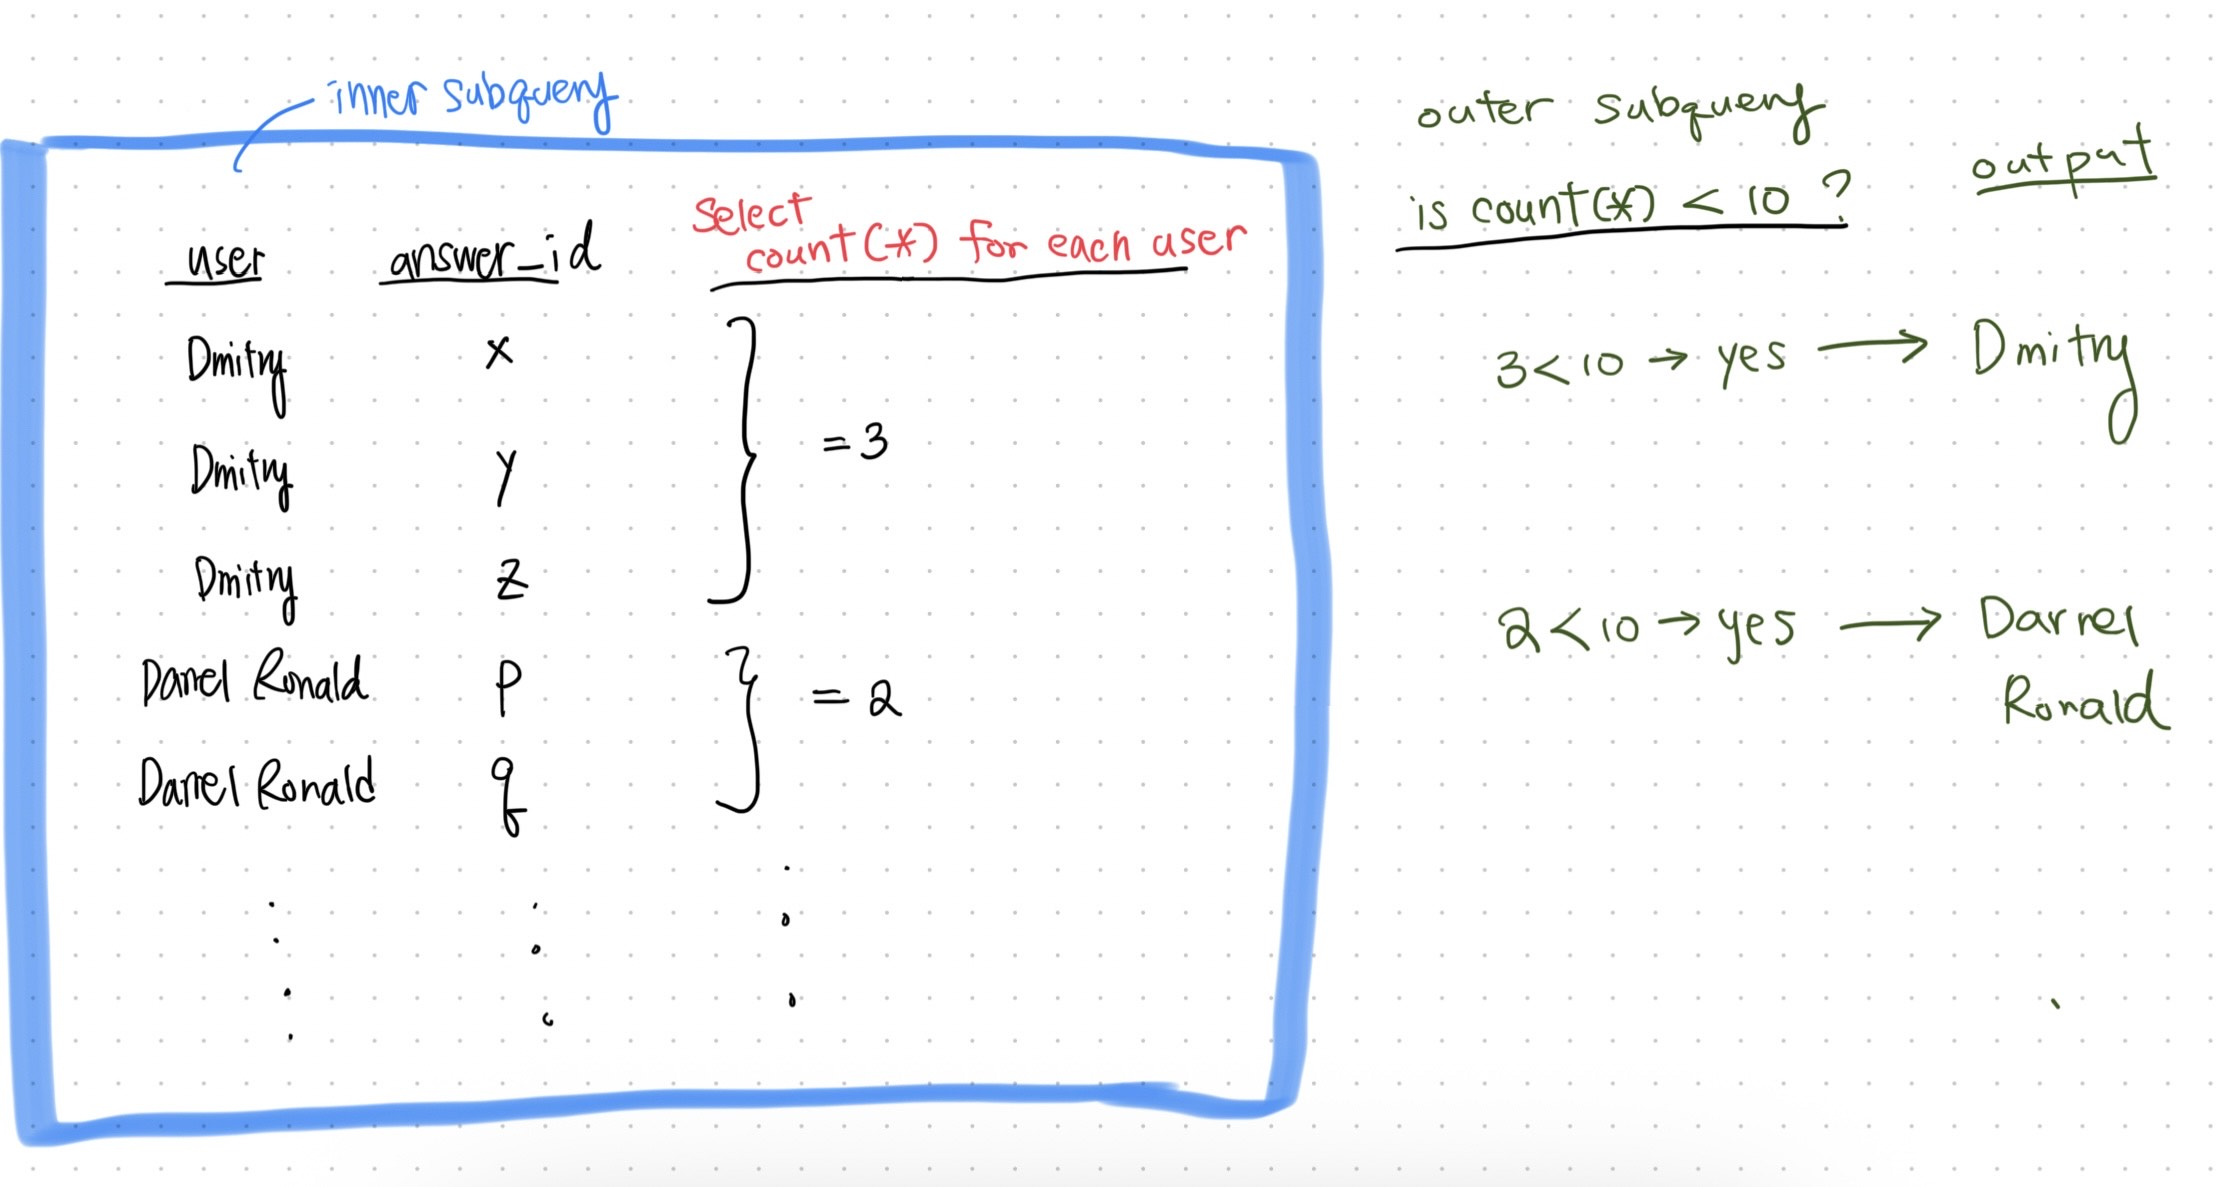

In [ ]:
%%bigquery --project $project_id
SELECT user.display_name as user_name
FROM `bigquery-public-data.stackoverflow.users` user
WHERE (
  SELECT COUNT(*)
  FROM `bigquery-public-data.stackoverflow.posts_answers` answers
  WHERE answers.owner_user_id = user.id
) < 10
LIMIT 10;

Query is running:   0%|          |

Downloading:   0%|          |

,user_name
0,Saubhagya Mishra
1,user2220227
2,Sb7an allah
3,Muhammad Hammad
4,21 character username
5,Darrel Ronald
6,sairamunsif
7,Pradeep Kumar Singh
8,Dmitriy
9,Marivic Lorilla


### SubQuery 2: Do question poster answer their own question?


In [150]:
%%bigquery --project $project_id

SELECT
  u.display_name as user_name,
FROM `bigquery-public-data.stackoverflow.users` u
WHERE EXISTS(
  SELECT 1
  FROM `bigquery-public-data.stackoverflow.posts_questions` q
  INNER JOIN `bigquery-public-data.stackoverflow.posts_answers` a
    ON q.id = a.parent_id
  WHERE q.owner_user_id = a.owner_user_id
    AND q.owner_user_id IS NOT NULL
    AND u.id = q.owner_user_id
)
LIMIT 10;

Query is running:   0%|          |

Downloading:   0%|          |

,user_name
0,Eric Lamb
1,Darren Oster
2,leek
3,chrisb
4,chroder
5,August Lilleaas
6,Ken Paul
7,John
8,Tom
9,airmind


## CTEs

2 queries with WITH clauses

### CTE 1: What are the earliest and latest complete record in this dataset?


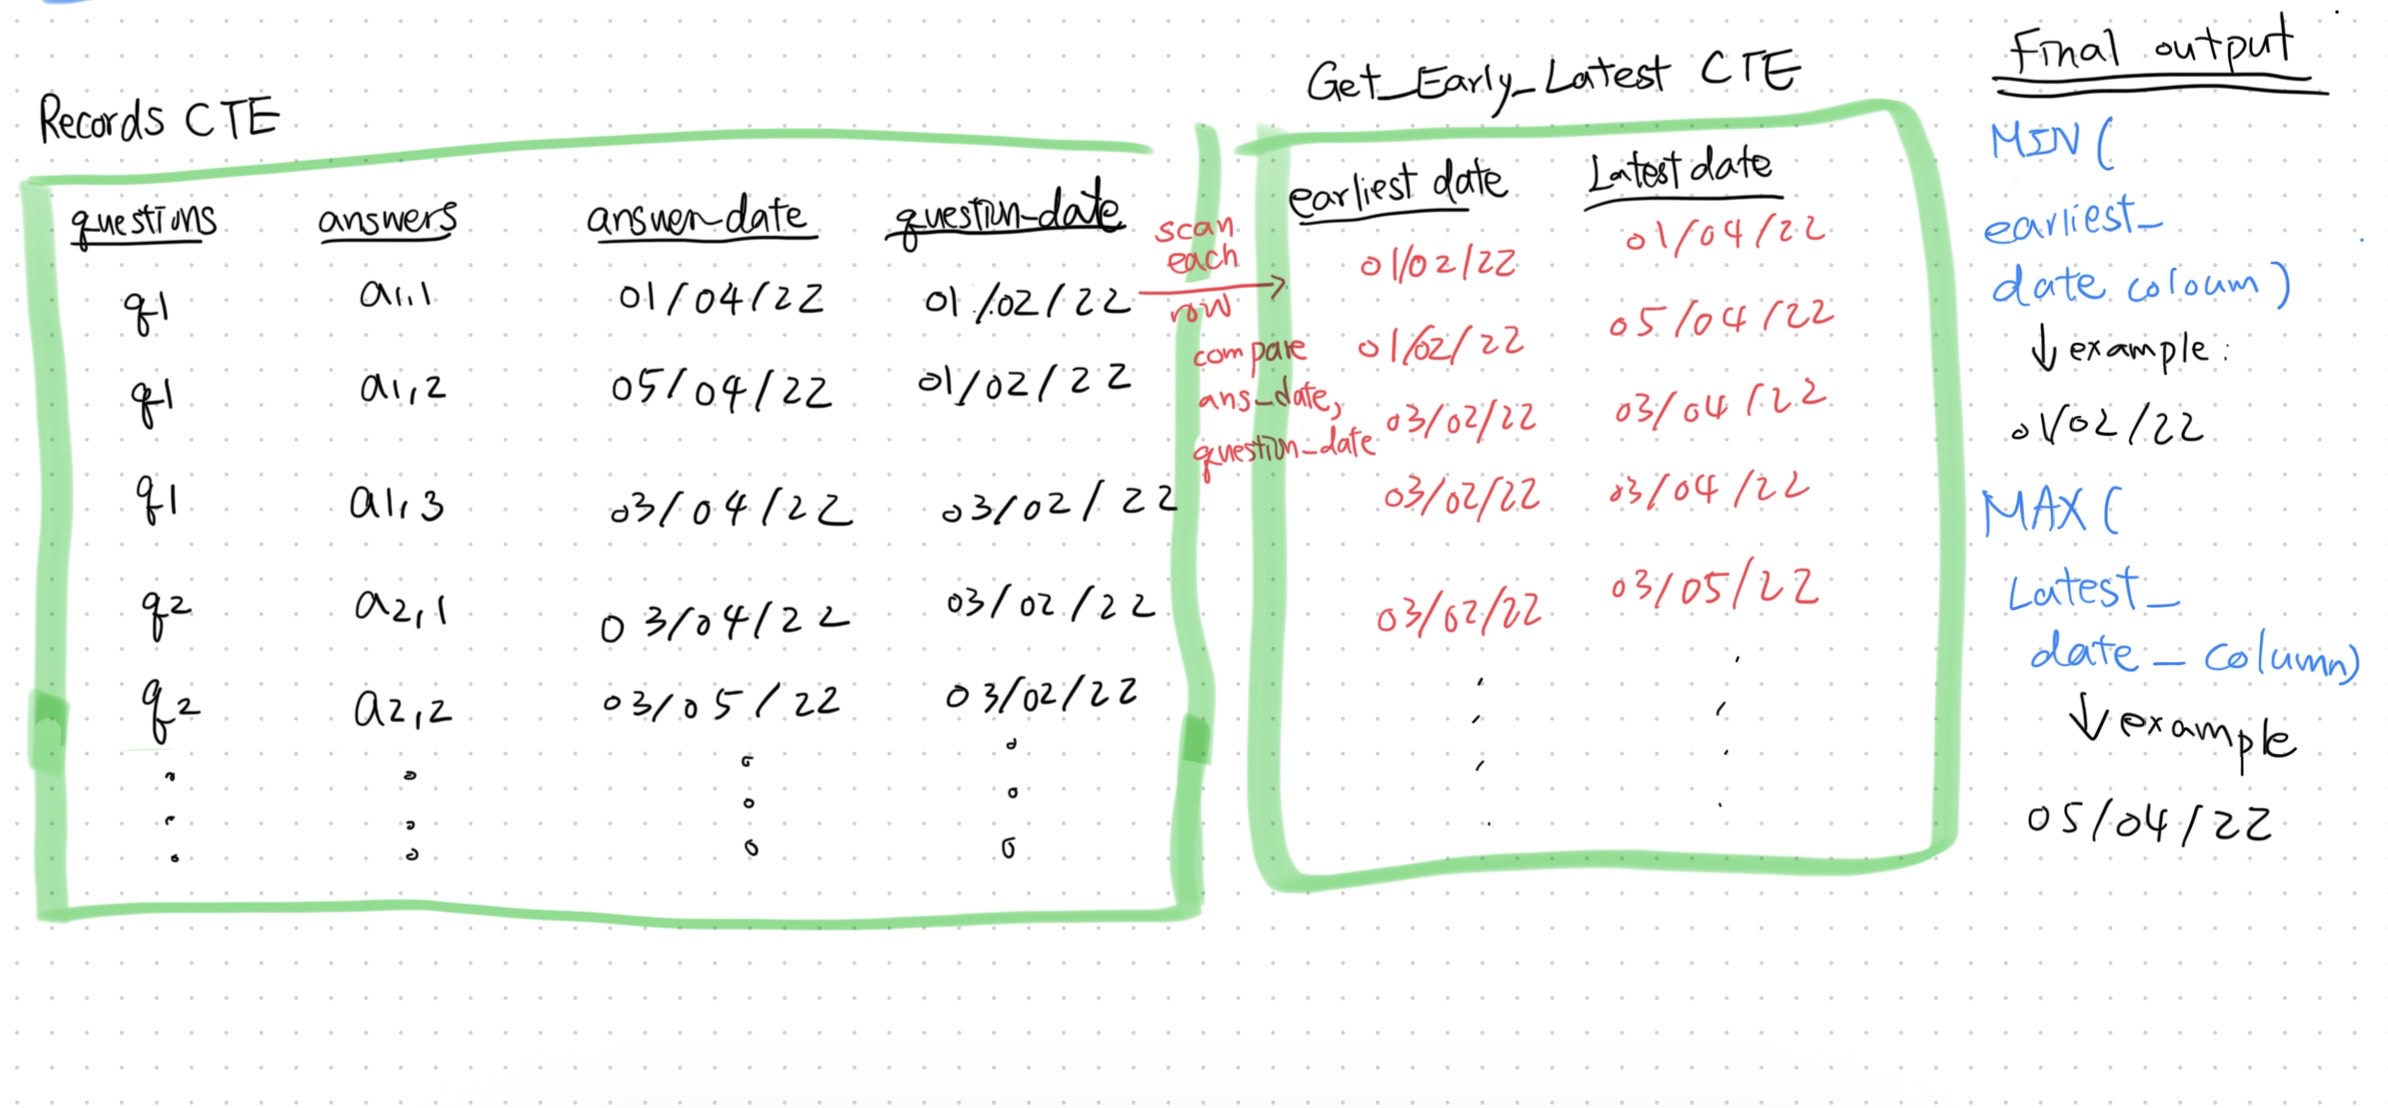

In [ ]:
# write code here
%%bigquery --project $project_id
WITH records AS (
   SELECT
  q.body AS question,
  a.body AS answers,
  q.creation_date AS question_date,
  a.creation_date AS answer_date
FROM `bigquery-public-data.stackoverflow.posts_questions` q
INNER JOIN `bigquery-public-data.stackoverflow.posts_answers` a
  ON q.id = a.parent_id
), get_early_latest AS (
SELECT
CASE
  WHEN question_date < answer_date THEN question_date
  ELSE answer_date
END AS earliest_date,
CASE
  WHEN question_date > answer_date THEN question_date
  ELSE answer_date
END AS latest_date
FROM records
WHERE question_date IS NOT NULL AND answer_date IS NOT NULL)
SELECT
MAX(latest_date) AS latest_date,
MIN(earliest_date) AS earliest_date
FROM get_early_latest;

Query is running:   0%|          |

Downloading:   0%|          |

,latest_date,earliest_date
0,2022-09-25 05:56:36.210000+00:00,2008-07-31 21:42:52.667000+00:00


### CTE 2: Users with top 10% of repuations who post the top 10% favorites questions


Please copy and paste your debug table image here for this query. Otherwise delete this cell.

In [ ]:
%%bigquery --project $project_id

WITH fav_bucket AS (
    SELECT
    owner_user_id as user_id,
    NTILE(10) OVER (ORDER BY favorite_count) as bucket
  FROM `bigquery-public-data.stackoverflow.posts_questions`
  WHERE favorite_count IS NOT NULL
), user_bucekt AS (
  SELECT
    display_name as user_name,
    id,
    NTILE(10) OVER (ORDER BY reputation) as bucket
  FROM `bigquery-public-data.stackoverflow.users`
  WHERE reputation IS NOT NULL
)
SELECT user_name
FROM user_bucekt as u
INNER JOIN fav_bucket as f
  ON u.id = f.user_id
WHERE u.bucket = 10 AND f.bucket = 10
-- SELECT bucket = 10 as it's order by ascending favorite count
--- the last bucket contains the ones with the highest favorite count
LIMIT 10


Query is running:   0%|          |

Downloading:   0%|          |

,user_name
0,izq
1,yuri
2,user3223207
3,Fco. Javier Martínez Conesa
4,Concept
5,Александр Ветров
6,Max
7,evgenyq
8,user1993617
9,androidisnotforme


## Window Functions

3 queries with OVER, including RANK vs ROW_NUMBER. Please note the FAQs!

### Window Function 1: Users, reputation < 500 and in either USA or England, partition by location , what are their ranks by the grade level of average answer score:
- score: < 0.5, grade: D
- score: 0.5~ 2, grade: C
- score: 2~10, grade: B
- score: >10, grade: A

In [190]:
%%bigquery --project $project_id
WITH stats_table AS (
  SELECT
    u.location,
    u.display_name,
    COUNT(a.id) as total_answers,
    AVG(a.score) as avg_answer_score,
    COUNT(a.favorite_count) as total_favorites
  FROM `bigquery-public-data.stackoverflow.users` u
  LEFT JOIN `bigquery-public-data.stackoverflow.posts_answers` a
      ON u.id = a.owner_user_id
  WHERE u.location IN ('USA', 'UK')
  GROUP BY u.location, u.display_name

), assign_grades AS (
  SELECT *,
    CASE
      WHEN avg_answer_score < 2 AND avg_answer_score > 0.5 THEN 'C'
      WHEN avg_answer_score >= 2 AND avg_answer_score < 10 THEN 'B'
      WHEN avg_answer_score >= 10 THEN 'A'
      ELSE 'D'
    END as answer_grade
  FROM stats_table
)
SELECT *,
  RANK() OVER (
    PARTITION BY location
    ORDER BY answer_grade
  ) as RankNum,
  ROW_NUMBER() OVER (
    PARTITION BY location
    ORDER BY answer_grade
  ) as RowNum
FROM assign_grades
QUALIFY RowNum <= 5
ORDER BY location

Query is running:   0%|          |

Downloading:   0%|          |

,location,display_name,total_answers,avg_answer_score,total_favorites,answer_grade,RankNum,RowNum
0,UK,coltaylor,1,11.000000,0,A,1,1
1,UK,meatballs,25,13.680000,0,A,1,2
2,UK,Bobbles,6,11.166667,0,A,1,3
3,UK,fyllepo,3,51.000000,0,A,1,4
4,UK,Voltronika,1,29.000000,0,A,1,5
5,USA,JoshuaDavid,40,35.175000,0,A,1,1
6,USA,mathwizurd,5,21.200000,0,A,1,2
7,USA,Cascabel,736,62.529891,0,A,1,3
8,USA,Kane Chew,7,41.142857,0,A,1,4
9,USA,Luke S.,1,29.000000,0,A,1,5


### Window Function 2: Questions in the year of 2020, partition by location (USA, England), rank by #favorite

In [193]:
%%bigquery --project $project_id
SELECT
    u.location,
    p.id as QuestionId,
    p.title,
    p.favorite_count,
    u.display_name as Author,
    p.creation_date,
    RANK() OVER (
        PARTITION BY u.location
        ORDER BY  p.score DESC, p.favorite_count DESC
    ) as FavoriteRank,
    ROW_NUMBER() OVER (
        PARTITION BY u.location
        ORDER BY p.score DESC, p.favorite_count DESC
    ) as RowNum
FROM `bigquery-public-data.stackoverflow.posts_questions` p
INNER JOIN `bigquery-public-data.stackoverflow.users` u
    ON p.owner_user_id = u.id
WHERE EXTRACT(YEAR FROM p.creation_date) = 2020
    AND u.location IS NOT NULL
    AND u.location != ''
    AND p.favorite_count > 0
    AND u.location in ('USA', 'England')
QUALIFY FavoriteRank <= 5
ORDER BY u.location
LIMIT 10

Query is running:   0%|          |

Downloading:   0%|          |

,location,QuestionId,title,favorite_count,Author,creation_date,FavoriteRank,RowNum
0,England,59875531,Upgrading xproj in Visual Studio 2019,3,Andrew,2020-01-23 09:45:36.357000+00:00,4,4
1,England,60564462,How to connect to a database using Active dire...,2,User1,2020-03-06 12:50:44.317000+00:00,5,5
2,England,59827818,How do I get parts of my GitLab CI Job Log to ...,1,TafT,2020-01-20 16:54:18.350000+00:00,3,3
3,England,64499328,"Google Chrome weird cursor blink on pages, nev...",10,Arun Panneerselvam,2020-10-23 11:41:35.390000+00:00,1,1
4,England,64374526,Is is necessary to use volatile when writing t...,1,Nigel Davies,2020-10-15 15:04:41.437000+00:00,2,2
5,USA,62964532,helm not creating the resources,4,harry123,2020-07-18 04:08:53.607000+00:00,5,5
6,USA,62140483,How to interpret dplyr message `summarise()` r...,35,Susie Derkins,2020-06-01 20:26:57.977000+00:00,1,1
7,USA,64095320,Mechanism to check if a C++ member is private,1,Connor Fuhrman,2020-09-28 02:44:55.823000+00:00,2,2
8,USA,62923230,Disable Chrome v 84 Issues Tab in JS console,1,Lauren Karl,2020-07-15 20:25:44.070000+00:00,4,4
9,USA,59596261,Return or yield from a function that calls a g...,5,hyankov,2020-01-05 01:16:48.123000+00:00,3,3


### Window Function 3: Users, parition by questions tags (specifically deep-learning and sql), get top 3 who answers the most questions


In [196]:
%%bigquery --project $project_id
WITH question_tags AS (
  SELECT
    q.id as question_id,
    tag
  FROM `bigquery-public-data.stackoverflow.posts_questions` q,
  UNNEST(SPLIT(tags, '|')) as tag
  WHERE tag IN ('deep-learning', 'sql')
),
answer_counts AS (
  SELECT
    qt.tag,
    a.owner_user_id,
    u.display_name,
    COUNT(a.id) as total_answers
  FROM question_tags qt
  JOIN `bigquery-public-data.stackoverflow.posts_answers` a
    ON qt.question_id = a.parent_id
  LEFT JOIN `bigquery-public-data.stackoverflow.users` u
    ON a.owner_user_id = u.id
  WHERE a.owner_user_id IS NOT NULL
  GROUP BY qt.tag, a.owner_user_id, u.display_name
)
SELECT
  tag,
  owner_user_id,
  display_name,
  total_answers,
  RANK() OVER (
    PARTITION BY tag
    ORDER BY total_answers DESC
  ) as rank_num,
  ROW_NUMBER() OVER (
    PARTITION BY tag
    ORDER BY total_answers DESC
  ) as row_num
FROM answer_counts
QUALIFY rank_num <= 3
ORDER BY tag, rank_num

Query is running:   0%|          |

Downloading:   0%|          |

,tag,owner_user_id,display_name,total_answers,rank_num,row_num
0,deep-learning,1714410,Shai,656,1,1
1,deep-learning,2097240,Daniel Möller,275,2,2
2,deep-learning,349130,Dr. Snoopy,234,3,3
3,sql,1144035,Gordon Linoff,76190,1,1
4,sql,10676716,GMB,10121,2,2
5,sql,1863229,Tim Biegeleisen,6535,3,3


# Section 4: Exploring Central Questions

Main Question - What are the emerging trends of knoweledege and their respective experts?

1. What are the top 3 new emerging trends and what trends are abandomed in the lastest year?
- query 1.1 get new trend: Identify tags that rank in top 50 by question volume in latest 12 months BUT were NOT in top 100 during years 2-4 ago AND have growth rate exceeding 150% year-over-year AND maintain 50%+ answer rate
- query 1.2 get abandoning trend: IDENTIFY tags that ranked in top 50 during years 2-4 ago BUT dropped to rank 100+ in latest 12 months AND question volume decreased 50%+ AND unanswered rate increased 20%

2. Who are the domain experts with the associated with the top new emerging trends?
- query 2.1: identify users WHO answered 30+ questions in emerging tags (from Q1.1) in the last 12 months AND have 60%+ acceptance rate on those emerging-tag answers AND average 8+ upvotes per answer in emerging tags but reputation < max(reputation) * 0.6

- query 2.2: get people who succesfully transitioned from old trending fields to new trending field: Identify users WHO ranked in top 20% by answer score in abandoned tags (from Q1.2) during years 4-6 ago AND now rank in top 20% by answer score in emerging tags (from Q1.1) in last 12 months AND maintain answer acceptance rate >= 50%

3. In which areas exist knowledge gap in the latest 3 year?
- q3.1 (identify tags where people don't know much about or contain misleading information): Identify tags WHERE question volume grew 100%+ in lastest 3 yr BUT average answerer reputation is below 5,000

- q3.2 (identify what do people want to know but don't know): FIND tags WHERE view-to-question ratio in (top 10% of all tags) AND answer rate in (bottom 20%) in latest 3 year




## Question 1: What are the top new trending topics and what topics are abandomed in the lastest year?

#### Query 1.1: Identify Emerging Trends

**Objective:** Find emerging tags that show significant recent growth but were previously underrepresented.

**Criteria:**
1. **Recent Activity (Last 1 Year):**
   - High question volume among tags not in the historical top 100
   - Quality threshold: Both questions and answers must have score ≥ 1 (indicating validity and non-spurious)
   - Answer rate ≥ 50% (indicating active community engagement)
   - For each tag, current year question volume > 2× the yearly average from years 1-4

2. **Historical Top 100 :**
   - time: 1-4 Years Ago
   - Quality threshold: Both questions and answers must have score ≥ 1 (indicating validity and non-spurious)


In [ ]:
# get latest date first from the database as the database stops updating already
%%bigquery --project $project_id
SELECT MAX(creation_date) AS latest_date
FROM `bigquery-public-data.stackoverflow.posts_questions`


Query is running:   0%|          |

Downloading:   0%|          |

,latest_date
0,2022-09-25 05:56:32.863000+00:00


In [143]:
%%bigquery --project $project_id
WITH recent_questions AS ( -- get all tags and questions with score >= 1 in latest 12 month
  SELECT DISTINCT
    tag_name,
    q.id AS question_id,
  FROM `bigquery-public-data.stackoverflow.posts_questions` q
  CROSS JOIN UNNEST(SPLIT(q.tags, '|')) AS tag_name
  WHERE q.creation_date >= TIMESTAMP(DATE_SUB(DATE('2022-09-25'), INTERVAL 12 MONTH))
    AND q.creation_date < TIMESTAMP('2022-09-25')
    AND q.score >= 1
  GROUP BY tag_name, question_id
),
recent_quality_answers AS ( -- get all tags, question, and answers with score >= 1
  SELECT DISTINCT
    q.id AS question_id,
    tag_name
  FROM `bigquery-public-data.stackoverflow.posts_questions` q
  CROSS JOIN UNNEST(SPLIT(q.tags, '|')) AS tag_name
  INNER JOIN `bigquery-public-data.stackoverflow.posts_answers` a
    ON q.id = a.parent_id
  WHERE q.creation_date >= TIMESTAMP(DATE_SUB(DATE('2022-09-25'), INTERVAL 12 MONTH))
    AND q.creation_date < TIMESTAMP('2022-09-25')
    AND a.score >= 1
    AND q.score >= 1
),
recent_tags AS ( -- left join recent_questions and recent_quality_answers,
--group by tag_name and question_id to make sure no duplicate questions for each tag
  SELECT
    rq.tag_name,
    rq.question_id,
    MAX(CASE WHEN rqa.question_id IS NOT NULL THEN 1 ELSE 0 END) AS has_quality_answer
  FROM recent_questions rq
  LEFT JOIN recent_quality_answers rqa
    ON rq.question_id = rqa.question_id
    AND rq.tag_name = rqa.tag_name
  GROUP BY tag_name, question_id
),
recent_tag_stats AS ( -- calculate some stats for recent tags, and select the ones with >50% answer rate
  SELECT
    tag_name,
    COUNT(question_id) AS total_questions,
    SUM(has_quality_answer) AS answered_questions,
    SUM(has_quality_answer) / COUNT( question_id) AS answer_rate,
    ROW_NUMBER() OVER (ORDER BY COUNT(question_id) DESC) AS rank
  FROM recent_tags
  GROUP BY tag_name
  HAVING answer_rate >= 0.5
), -- repeat the above steps for old_questions, old_quality_answers, and old_tags
old_questions AS (
  SELECT DISTINCT
    tag_name,
    q.id AS question_id,
  FROM `bigquery-public-data.stackoverflow.posts_questions` q
  CROSS JOIN UNNEST(SPLIT(q.tags, '|')) AS tag_name
  WHERE q.creation_date >= TIMESTAMP(DATE_SUB(DATE('2022-09-25'), INTERVAL 48 MONTH))
    AND q.creation_date < TIMESTAMP(DATE_SUB(DATE('2022-09-25'), INTERVAL 12 MONTH))
    AND q.score >= 1
  GROUP BY tag_name, question_id
),
old_quality_answers AS (
  SELECT DISTINCT
    q.id AS question_id,
    tag_name
  FROM `bigquery-public-data.stackoverflow.posts_questions` q
  CROSS JOIN UNNEST(SPLIT(q.tags, '|')) AS tag_name
  INNER JOIN `bigquery-public-data.stackoverflow.posts_answers` a
    ON q.id = a.parent_id
  WHERE q.creation_date >= TIMESTAMP(DATE_SUB(DATE('2022-09-25'), INTERVAL 48 MONTH))
    AND q.creation_date < TIMESTAMP(DATE_SUB(DATE('2022-09-25'), INTERVAL 12 MONTH))
    AND a.score >= 1
    AND q.score >= 1
),
old_tags AS (
  SELECT
    oq.tag_name,
    oq.question_id,
    MAX(CASE WHEN oqa.question_id IS NOT NULL THEN 1 ELSE 0 END) AS has_quality_answer
  FROM old_questions oq
  LEFT JOIN old_quality_answers oqa
    ON oq.question_id = oqa.question_id
    AND oq.tag_name = oqa.tag_name
  GROUP BY tag_name, question_id
),
old_stats AS (
  SELECT
    tag_name,
    COUNT(DISTINCT question_id) AS total_questions,
    SUM(has_quality_answer) AS answered_questions,
    SUM(has_quality_answer) / COUNT(DISTINCT question_id) AS answer_rate,
    ROW_NUMBER() OVER (ORDER BY COUNT(DISTINCT question_id) DESC) AS rank
  FROM old_tags
  GROUP BY tag_name
)
-- left join recent_tag_stats with old_tag_stats, only keeping "emerging" tags
SELECT
  r.tag_name,
  r.total_questions as recent_yr_total_questions,
  r.answer_rate AS recent_answer_rate,
  FLOOR(o.total_questions / 3) as old_total_questions_per_yr,
  o.answer_rate AS old_answer_rate,
  r.rank AS new_rank,
  o.rank AS old_rank
FROM recent_tag_stats AS r
LEFT JOIN old_stats AS o
  ON r.tag_name = o.tag_name
WHERE r.rank <= 100
  AND r.tag_name NOT IN (
    SELECT tag_name
    FROM old_stats
    WHERE rank <= 100
  )
  AND (r.total_questions / (o.total_questions / 3)) >= 2
ORDER BY r.total_questions DESC



Query is running:   0%|          |

Downloading:   0%|          |

,tag_name,recent_yr_total_questions,recent_answer_rate,old_total_questions_per_yr,old_answer_rate,new_rank,old_rank
0,android-jetpack-compose,2038,0.653582,531.0,0.821092,54,499
1,snowflake-cloud-data-platform,1568,0.691327,711.0,0.732427,68,382
2,vuejs3,1566,0.607280,513.0,0.734416,69,513
3,.net-6.0,1299,0.577367,12.0,0.815789,81,10068
4,react-router-dom,1246,0.665329,505.0,0.629703,85,521
5,tailwind-css,1111,0.568857,377.0,0.708223,94,691


#### query 1.2 get trend: Identify trends that are losing momentum
Criteria for popular tags in historial context but loosing traction in recent year:
- that ranked in top 200 in question volumne 1-4 yr ago BUT dropped to rank 300+ in latest 12 months
- answer rate > 50%
- question and answer score >= 1
- yearly average question count > 2* recent year question count <br>
(criteria selected for reasons same as Q1.1)



In [146]:
%%bigquery --project $project_id
WITH recent_questions AS ( -- get all tags and questions with score >= 1 in latest 12 month
  SELECT DISTINCT
    tag_name,
    q.id AS question_id,
  FROM `bigquery-public-data.stackoverflow.posts_questions` q
  CROSS JOIN UNNEST(SPLIT(q.tags, '|')) AS tag_name
  WHERE q.creation_date >= TIMESTAMP(DATE_SUB(DATE('2022-09-25'), INTERVAL 12 MONTH))
    AND q.creation_date < TIMESTAMP('2022-09-25')
    AND q.score >= 1
  GROUP BY tag_name, question_id
),
recent_quality_answers AS ( -- get all tags, question, and answers with score >= 1
  SELECT DISTINCT
    q.id AS question_id,
    tag_name
  FROM `bigquery-public-data.stackoverflow.posts_questions` q
  CROSS JOIN UNNEST(SPLIT(q.tags, '|')) AS tag_name
  INNER JOIN `bigquery-public-data.stackoverflow.posts_answers` a
    ON q.id = a.parent_id
  WHERE q.creation_date >= TIMESTAMP(DATE_SUB(DATE('2022-09-25'), INTERVAL 12 MONTH))
    AND q.creation_date < TIMESTAMP('2022-09-25')
    AND a.score >= 1
    AND q.score >= 1
),
recent_tags AS ( -- left join recent_questions and recent_quality_answers,
--group by tag_name and question_id to make sure no duplicate questions for each tag
  SELECT
    rq.tag_name,
    rq.question_id,
    MAX(CASE WHEN rqa.question_id IS NOT NULL THEN 1 ELSE 0 END) AS has_quality_answer
  FROM recent_questions rq
  LEFT JOIN recent_quality_answers rqa
    ON rq.question_id = rqa.question_id
    AND rq.tag_name = rqa.tag_name
  GROUP BY tag_name, question_id
),
recent_tag_stats AS ( -- calculate some stats for recent tags, and select the ones with >50% answer rate
  SELECT
    tag_name,
    COUNT(question_id) AS total_questions,
    SUM(has_quality_answer) AS answered_questions,
    SUM(has_quality_answer) / COUNT( question_id) AS answer_rate,
    ROW_NUMBER() OVER (ORDER BY COUNT(question_id) DESC) AS rank
  FROM recent_tags
  GROUP BY tag_name
  --HAVING answer_rate >= 0.5
), -- repeat the above steps for old_questions, old_quality_answers, and old_tags
old_questions AS (
  SELECT DISTINCT
    tag_name,
    q.id AS question_id,
  FROM `bigquery-public-data.stackoverflow.posts_questions` q
  CROSS JOIN UNNEST(SPLIT(q.tags, '|')) AS tag_name
  WHERE q.creation_date >= TIMESTAMP(DATE_SUB(DATE('2022-09-25'), INTERVAL 48 MONTH))
    AND q.creation_date < TIMESTAMP(DATE_SUB(DATE('2022-09-25'), INTERVAL 12 MONTH))
    AND q.score >= 1
  GROUP BY tag_name, question_id
),
old_quality_answers AS (
  SELECT DISTINCT
    q.id AS question_id,
    tag_name
  FROM `bigquery-public-data.stackoverflow.posts_questions` q
  CROSS JOIN UNNEST(SPLIT(q.tags, '|')) AS tag_name
  INNER JOIN `bigquery-public-data.stackoverflow.posts_answers` a
    ON q.id = a.parent_id
  WHERE q.creation_date >= TIMESTAMP(DATE_SUB(DATE('2022-09-25'), INTERVAL 48 MONTH))
    AND q.creation_date < TIMESTAMP(DATE_SUB(DATE('2022-09-25'), INTERVAL 12 MONTH))
    AND a.score >= 1
    AND q.score >= 1
),
old_tags AS (
  SELECT
    oq.tag_name,
    oq.question_id,
    MAX(CASE WHEN oqa.question_id IS NOT NULL THEN 1 ELSE 0 END) AS has_quality_answer
  FROM old_questions oq
  LEFT JOIN old_quality_answers oqa
    ON oq.question_id = oqa.question_id
    AND oq.tag_name = oqa.tag_name
  GROUP BY tag_name, question_id
),
old_stats AS (
  SELECT
    tag_name,
    COUNT(DISTINCT question_id) AS total_questions,
    SUM(has_quality_answer) AS answered_questions,
    SUM(has_quality_answer) / COUNT(DISTINCT question_id) AS answer_rate,
    ROW_NUMBER() OVER (ORDER BY COUNT(DISTINCT question_id) DESC) AS rank
  FROM old_tags
  GROUP BY tag_name
  HAVING answer_rate >= 0.5
)
-- left join old_tag_stats with recent tags, keeping tags that ranks top 200 previosly but drop out top 300 latest 12 month
SELECT
  o.tag_name,
  FLOOR(o.total_questions / 3) as old_total_questions_per_yr,
  r.total_questions as recent_yr_total_questions,
  o.rank AS old_rank,
  r.rank AS new_rank,
  r.answer_rate AS recent_answer_rate,
  o.answer_rate AS old_answer_rate,
FROM old_stats AS o
LEFT JOIN recent_tag_stats AS r
  ON o.tag_name = r.tag_name
WHERE o.rank <= 200
AND o.tag_name NOT IN (
  SELECT tag_name
  FROM recent_tag_stats
  WHERE rank <= 300
) AND ((o.total_questions / 3) / r.total_questions) >= 2
ORDER BY o.total_questions DESC
LIMIT 10


Query is running:   0%|          |

Downloading:   0%|          |

,tag_name,old_total_questions_per_yr,recent_yr_total_questions,old_rank,new_rank,recent_answer_rate,old_answer_rate
0,bootstrap-4,1906.0,538,136,312,0.460967,0.609722
1,ecmascript-6,1636.0,450,157,374,0.682222,0.772209
2,angular-material,1587.0,460,160,365,0.447826,0.686056
3,tsql,1447.0,568,179,305,0.735915,0.770435
4,python-2.7,1381.0,223,189,732,0.493274,0.618094
5,java-8,1350.0,294,192,562,0.676871,0.837778


## Question 2:


#### Q2.1 Who are the experts in the top 10 emerging trends identified in q 1.1?
Criteria for experts:
1. with a good reputation (reputation > 500)
2. for each emerging tag, during 2021/09/25 ~2022/09/25, answers >= 20 questions and have an average answer score of >=1

In [148]:
%%bigquery --project $project_id
------- < the CTEs in this block are from q1.1 > ---------
WITH recent_questions AS ( -- get all tags and questions with score >= 1 in latest 12 month
  SELECT DISTINCT
    tag_name,
    q.id AS question_id,
  FROM `bigquery-public-data.stackoverflow.posts_questions` q
  CROSS JOIN UNNEST(SPLIT(q.tags, '|')) AS tag_name
  WHERE q.creation_date >= TIMESTAMP(DATE_SUB(DATE('2022-09-25'), INTERVAL 12 MONTH))
    AND q.creation_date < TIMESTAMP('2022-09-25')
    AND q.score >= 1
  GROUP BY tag_name, question_id
),
recent_quality_answers AS ( -- get all tags, question, and answers with score >= 1
  SELECT DISTINCT
    q.id AS question_id,
    tag_name
  FROM `bigquery-public-data.stackoverflow.posts_questions` q
  CROSS JOIN UNNEST(SPLIT(q.tags, '|')) AS tag_name
  INNER JOIN `bigquery-public-data.stackoverflow.posts_answers` a
    ON q.id = a.parent_id
  WHERE q.creation_date >= TIMESTAMP(DATE_SUB(DATE('2022-09-25'), INTERVAL 12 MONTH))
    AND q.creation_date < TIMESTAMP('2022-09-25')
    AND a.score >= 1
    AND q.score >= 1
),
recent_tags AS ( -- left join recent_questions and recent_quality_answers,
--group by tag_name and question_id to make sure no duplicate questions for each tag
  SELECT
    rq.tag_name,
    rq.question_id,
    MAX(CASE WHEN rqa.question_id IS NOT NULL THEN 1 ELSE 0 END) AS has_quality_answer
  FROM recent_questions rq
  LEFT JOIN recent_quality_answers rqa
    ON rq.question_id = rqa.question_id
    AND rq.tag_name = rqa.tag_name
  GROUP BY tag_name, question_id
),
recent_tag_stats AS ( -- calculate some stats for recent tags, and select the ones with >50% answer rate
  SELECT
    tag_name,
    COUNT(question_id) AS total_questions,
    SUM(has_quality_answer) AS answered_questions,
    SUM(has_quality_answer) / COUNT( question_id) AS answer_rate,
    ROW_NUMBER() OVER (ORDER BY COUNT(question_id) DESC) AS rank
  FROM recent_tags
  GROUP BY tag_name
  HAVING answer_rate >= 0.5
), -- repeat the above steps for old_questions, old_quality_answers, and old_tags
old_questions AS (
  SELECT DISTINCT
    tag_name,
    q.id AS question_id,
  FROM `bigquery-public-data.stackoverflow.posts_questions` q
  CROSS JOIN UNNEST(SPLIT(q.tags, '|')) AS tag_name
  WHERE q.creation_date >= TIMESTAMP(DATE_SUB(DATE('2022-09-25'), INTERVAL 48 MONTH))
    AND q.creation_date < TIMESTAMP(DATE_SUB(DATE('2022-09-25'), INTERVAL 12 MONTH))
    AND q.score >= 1
  GROUP BY tag_name, question_id
),
old_quality_answers AS (
  SELECT DISTINCT
    q.id AS question_id,
    tag_name
  FROM `bigquery-public-data.stackoverflow.posts_questions` q
  CROSS JOIN UNNEST(SPLIT(q.tags, '|')) AS tag_name
  INNER JOIN `bigquery-public-data.stackoverflow.posts_answers` a
    ON q.id = a.parent_id
  WHERE q.creation_date >= TIMESTAMP(DATE_SUB(DATE('2022-09-25'), INTERVAL 48 MONTH))
    AND q.creation_date < TIMESTAMP(DATE_SUB(DATE('2022-09-25'), INTERVAL 12 MONTH))
    AND a.score >= 1
    AND q.score >= 1
),
old_tags AS (
  SELECT
    oq.tag_name,
    oq.question_id,
    MAX(CASE WHEN oqa.question_id IS NOT NULL THEN 1 ELSE 0 END) AS has_quality_answer
  FROM old_questions oq
  LEFT JOIN old_quality_answers oqa
    ON oq.question_id = oqa.question_id
    AND oq.tag_name = oqa.tag_name
  GROUP BY tag_name, question_id
),
old_stats AS (
  SELECT
    tag_name,
    COUNT(DISTINCT question_id) AS total_questions,
    SUM(has_quality_answer) AS answered_questions,
    SUM(has_quality_answer) / COUNT(DISTINCT question_id) AS answer_rate,
    ROW_NUMBER() OVER (ORDER BY COUNT(DISTINCT question_id) DESC) AS rank
  FROM old_tags
  GROUP BY tag_name
)
-- left join recent_tag_stats with old_tag_stats, only keeping "emerging" tags
,TOP_emerging_tags AS (
SELECT
  r.tag_name,
  r.total_questions as recent_yr_total_questions,
  r.answer_rate AS recent_answer_rate,
  FLOOR(o.total_questions / 3) as old_total_questions_per_yr,
  o.answer_rate AS old_answer_rate,
  r.rank AS new_rank,
  o.rank AS old_rank
FROM recent_tag_stats AS r
LEFT JOIN old_stats AS o
  ON r.tag_name = o.tag_name
WHERE r.rank <= 100
  AND r.tag_name NOT IN (
    SELECT tag_name
    FROM old_stats
    WHERE rank <= 100
  )
  AND (r.total_questions / (o.total_questions / 3)) >= 2
ORDER BY r.total_questions DESC
), ------- < the CTEs in this block are from q1.1 > ---------
# get q&A records from the latest 12 month, and join them with emerging_tags and the user table
# only selecting user with a reputation of >= 500, indicating regular contribution with consistent quality
get_emerging_tags_user AS (
  SELECT
    a.owner_user_id,
    a.id AS answer_id,
    a.score AS answer_score,
    a.creation_date,
    q.id AS question_id,
    tag_name,
    u.display_name,
    u.reputation
  FROM `bigquery-public-data.stackoverflow.posts_answers` a
  INNER JOIN `bigquery-public-data.stackoverflow.posts_questions` q
    ON a.parent_id = q.id
  CROSS JOIN UNNEST(SPLIT(q.tags, '|')) AS tag_name
  INNER JOIN TOP_emerging_tags top_tags
    ON tag_name = top_tags.tag_name
  INNER JOIN `bigquery-public-data.stackoverflow.users` u
    ON  a.owner_user_id = u.id
  WHERE a.creation_date >= TIMESTAMP(DATE_SUB(DATE('2022-09-25'), INTERVAL 12 MONTH))
    AND a.creation_date < TIMESTAMP('2022-09-25')
    AND a.owner_user_id IS NOT NULL
    AND u.reputation >= 500
),
# for each tag and each user, filter down the one in which each user answer > 20 questions and
# has an average answer score >= 1
get_user_stats AS (
  SELECT
    owner_user_id,
    display_name,
    tag_name,
    COUNT(DISTINCT gta.answer_id) AS total_answers,
    ROUND(AVG(gta.answer_score), 2) AS avg_answer_score
    FROM get_emerging_tags_user gta
    GROUP BY owner_user_id, display_name, tag_name
    HAVING total_answers >= 20 AND avg_answer_score >= 1
), ranked_users AS (
  SELECT
    *,
    RANK() OVER (PARTITION BY tag_name ORDER BY avg_answer_score DESC) AS score_rank,
    RANK() OVER (PARTITION BY tag_name ORDER BY total_answers DESC) AS answer_rank
  FROM get_user_stats
)
SELECT
tag_name,
display_name,
total_answers,
avg_answer_score,
score_rank,
answer_rank
FROM ranked_users
WHERE score_rank = 1 OR answer_rank = 1
ORDER BY tag_name



Query is running:   0%|          |

Downloading:   0%|          |

,tag_name,display_name,total_answers,avg_answer_score,score_rank,answer_rank
0,.net-6.0,Guru Stron,157,4.97,1,1
1,android-jetpack-compose,Phil Dukhov,422,2.95,2,1
2,android-jetpack-compose,ianhanniballake,21,3.24,1,13
3,react-router-dom,Drew Reese,913,1.78,1,1
4,snowflake-cloud-data-platform,Lukasz Szozda,516,1.24,3,1
5,snowflake-cloud-data-platform,Felipe Hoffa,160,1.44,1,3
6,tailwind-css,Ed Lucas,52,1.02,5,1
7,tailwind-css,doğukan,24,8.17,1,4
8,vuejs3,tony19,259,2.31,2,1
9,vuejs3,Roland,24,3.08,1,9


####Q 2.2 What are the top 3 tags these experts associated with (by number of answers and by answer scores)?

In [149]:
%%bigquery --project $project_id
------- < the CTEs in this block are from q1.1 > ---------
WITH recent_questions AS ( -- get all tags and questions with score >= 1 in latest 12 month
  SELECT DISTINCT
    tag_name,
    q.id AS question_id,
  FROM `bigquery-public-data.stackoverflow.posts_questions` q
  CROSS JOIN UNNEST(SPLIT(q.tags, '|')) AS tag_name
  WHERE q.creation_date >= TIMESTAMP(DATE_SUB(DATE('2022-09-25'), INTERVAL 12 MONTH))
    AND q.creation_date < TIMESTAMP('2022-09-25')
    AND q.score >= 1
  GROUP BY tag_name, question_id
),
recent_quality_answers AS ( -- get all tags, question, and answers with score >= 1
  SELECT DISTINCT
    q.id AS question_id,
    tag_name
  FROM `bigquery-public-data.stackoverflow.posts_questions` q
  CROSS JOIN UNNEST(SPLIT(q.tags, '|')) AS tag_name
  INNER JOIN `bigquery-public-data.stackoverflow.posts_answers` a
    ON q.id = a.parent_id
  WHERE q.creation_date >= TIMESTAMP(DATE_SUB(DATE('2022-09-25'), INTERVAL 12 MONTH))
    AND q.creation_date < TIMESTAMP('2022-09-25')
    AND a.score >= 1
    AND q.score >= 1
),
recent_tags AS ( -- left join recent_questions and recent_quality_answers,
--group by tag_name and question_id to make sure no duplicate questions for each tag
  SELECT
    rq.tag_name,
    rq.question_id,
    MAX(CASE WHEN rqa.question_id IS NOT NULL THEN 1 ELSE 0 END) AS has_quality_answer
  FROM recent_questions rq
  LEFT JOIN recent_quality_answers rqa
    ON rq.question_id = rqa.question_id
    AND rq.tag_name = rqa.tag_name
  GROUP BY tag_name, question_id
),
recent_tag_stats AS ( -- calculate some stats for recent tags, and select the ones with >50% answer rate
  SELECT
    tag_name,
    COUNT(question_id) AS total_questions,
    SUM(has_quality_answer) AS answered_questions,
    SUM(has_quality_answer) / COUNT( question_id) AS answer_rate,
    ROW_NUMBER() OVER (ORDER BY COUNT(question_id) DESC) AS rank
  FROM recent_tags
  GROUP BY tag_name
  HAVING answer_rate >= 0.5
), -- repeat the above steps for old_questions, old_quality_answers, and old_tags
old_questions AS (
  SELECT DISTINCT
    tag_name,
    q.id AS question_id,
  FROM `bigquery-public-data.stackoverflow.posts_questions` q
  CROSS JOIN UNNEST(SPLIT(q.tags, '|')) AS tag_name
  WHERE q.creation_date >= TIMESTAMP(DATE_SUB(DATE('2022-09-25'), INTERVAL 48 MONTH))
    AND q.creation_date < TIMESTAMP(DATE_SUB(DATE('2022-09-25'), INTERVAL 12 MONTH))
    AND q.score >= 1
  GROUP BY tag_name, question_id
),
old_quality_answers AS (
  SELECT DISTINCT
    q.id AS question_id,
    tag_name
  FROM `bigquery-public-data.stackoverflow.posts_questions` q
  CROSS JOIN UNNEST(SPLIT(q.tags, '|')) AS tag_name
  INNER JOIN `bigquery-public-data.stackoverflow.posts_answers` a
    ON q.id = a.parent_id
  WHERE q.creation_date >= TIMESTAMP(DATE_SUB(DATE('2022-09-25'), INTERVAL 48 MONTH))
    AND q.creation_date < TIMESTAMP(DATE_SUB(DATE('2022-09-25'), INTERVAL 12 MONTH))
    AND a.score >= 1
    AND q.score >= 1
),
old_tags AS (
  SELECT
    oq.tag_name,
    oq.question_id,
    MAX(CASE WHEN oqa.question_id IS NOT NULL THEN 1 ELSE 0 END) AS has_quality_answer
  FROM old_questions oq
  LEFT JOIN old_quality_answers oqa
    ON oq.question_id = oqa.question_id
    AND oq.tag_name = oqa.tag_name
  GROUP BY tag_name, question_id
),
old_stats AS (
  SELECT
    tag_name,
    COUNT(DISTINCT question_id) AS total_questions,
    SUM(has_quality_answer) AS answered_questions,
    SUM(has_quality_answer) / COUNT(DISTINCT question_id) AS answer_rate,
    ROW_NUMBER() OVER (ORDER BY COUNT(DISTINCT question_id) DESC) AS rank
  FROM old_tags
  GROUP BY tag_name
)
-- left join recent_tag_stats with old_tag_stats, only keeping "emerging" tags
,TOP_emerging_tags AS (
SELECT
  r.tag_name,
  r.total_questions as recent_yr_total_questions,
  r.answer_rate AS recent_answer_rate,
  FLOOR(o.total_questions / 3) as old_total_questions_per_yr,
  o.answer_rate AS old_answer_rate,
  r.rank AS new_rank,
  o.rank AS old_rank
FROM recent_tag_stats AS r
LEFT JOIN old_stats AS o
  ON r.tag_name = o.tag_name
WHERE r.rank <= 100
  AND r.tag_name NOT IN (
    SELECT tag_name
    FROM old_stats
    WHERE rank <= 100
  )
  AND (r.total_questions / (o.total_questions / 3)) >= 2
ORDER BY r.total_questions DESC
), ------- < the CTEs in this block are from q1.1 > ---------,
# get q&A records from the latest 12 month, and join them with emerging_tags and the user table
# only selecting user with a reputation of >= 500, indicating regular contribution with consistent quality
get_emerging_tags_user AS (
  SELECT
    a.owner_user_id,
    a.id AS answer_id,
    a.score AS answer_score,
    a.creation_date,
    q.id AS question_id,
    tag_name,
    u.display_name,
    u.reputation
  FROM `bigquery-public-data.stackoverflow.posts_answers` a
  INNER JOIN `bigquery-public-data.stackoverflow.posts_questions` q
    ON a.parent_id = q.id
  CROSS JOIN UNNEST(SPLIT(q.tags, '|')) AS tag_name
  INNER JOIN TOP_emerging_tags top_tags
    ON tag_name = top_tags.tag_name
  INNER JOIN `bigquery-public-data.stackoverflow.users` u
    ON  a.owner_user_id = u.id
  WHERE a.creation_date >= TIMESTAMP(DATE_SUB(DATE('2022-09-25'), INTERVAL 12 MONTH))
    AND a.creation_date < TIMESTAMP('2022-09-25')
    AND a.owner_user_id IS NOT NULL
    AND u.reputation >= 500
), get_user_stats AS (
  SELECT
    owner_user_id,
    display_name,
    tag_name,
    COUNT(DISTINCT gta.answer_id) AS total_answers,
    ROUND(AVG(gta.answer_score), 2) AS avg_answer_score
    FROM get_emerging_tags_user gta
    GROUP BY owner_user_id, display_name, tag_name
    HAVING total_answers >= 20 AND avg_answer_score >= 1
), ranked_users AS (
  SELECT
    *,
    RANK() OVER (PARTITION BY tag_name ORDER BY avg_answer_score DESC) AS score_rank,
    RANK() OVER (PARTITION BY tag_name ORDER BY total_answers DESC) AS answer_rank
  FROM get_user_stats
), # the top experts identified in Q2.1
top_experts AS (
  SELECT DISTINCT
    owner_user_id,
    display_name
  FROM ranked_users
  WHERE score_rank = 1 OR answer_rank = 1
),
user_all_time_tags AS (
  SELECT
    a.owner_user_id,
    te.display_name,
    tag_name,
    COUNT(DISTINCT a.id) AS lifetime_answers_per_tag,
    ROUND(AVG(a.score), 2) AS lifetime_avg_score_per_tag
  FROM `bigquery-public-data.stackoverflow.posts_answers` a
  INNER JOIN `bigquery-public-data.stackoverflow.posts_questions` q
    ON a.parent_id = q.id
  CROSS JOIN UNNEST(SPLIT(q.tags, '|')) AS tag_name
  INNER JOIN top_experts te
    ON a.owner_user_id = te.owner_user_id
  WHERE a.owner_user_id IS NOT NULL
  GROUP BY a.owner_user_id, te.display_name, tag_name
),
ranked_lifetime_tags AS (
  SELECT
    *,
    ROW_NUMBER() OVER (
      PARTITION BY owner_user_id
      ORDER BY lifetime_answers_per_tag DESC, lifetime_avg_score_per_tag DESC
    ) AS tag_rank,
  CASE
   WHEN tag_name in (
    SELECT tag_name
    FROM TOP_emerging_tags
   ) THEN TRUE
   ELSE FALSE
   END AS is_emerging_tag
  FROM user_all_time_tags
)

SELECT
display_name,
tag_name,
is_emerging_tag,
lifetime_answers_per_tag,
lifetime_avg_score_per_tag,
tag_rank
FROM ranked_lifetime_tags
WHERE tag_rank <= 3
ORDER BY owner_user_id, tag_rank

Query is running:   0%|          |

Downloading:   0%|          |

,display_name,tag_name,is_emerging_tag,lifetime_answers_per_tag,lifetime_avg_score_per_tag,tag_rank
0,Felipe Hoffa,google-bigquery,False,897,3.37,1
1,Felipe Hoffa,snowflake-cloud-data-platform,True,423,1.44,2
2,Felipe Hoffa,sql,False,330,2.43,3
3,Ed Lucas,javascript,False,195,0.96,1
4,Ed Lucas,reactjs,False,113,1.03,2
5,Ed Lucas,html,False,58,0.69,3
6,ianhanniballake,android,False,2480,6.00,1
7,ianhanniballake,java,False,358,3.04,2
8,ianhanniballake,android-fragments,False,272,5.03,3
9,Guru Stron,c#,False,1331,2.21,1


## Question 3: What are the knowledge gap in the latest 12 months?
Knowledge gap is defined as:
 (1) high views, low answer rate
 (2) high question count, low answer rate
 (3) high question count, high answer rate, low answer score and low acceptance rate
 (4) low question count,  high view count, and low answer rate

In [147]:
%%bigquery --project $project_id
WITH recent_tags AS ( -- get all tags in the latest 12 month, make sure each tag is associated distinct questions
  SELECT
    tag_name,
    q.id AS question_id,
    MAX(q.creation_date) as creation_date,
    MAX(q.answer_count) as answer_count,
    MAX(q.view_count) AS question_view_count,
    CASE WHEN MAX(q.answer_count) > 0 THEN 1 ELSE 0 END AS is_answered,
    CASE WHEN MAX(q.accepted_answer_id) IS NOT NULL THEN 1 ELSE 0 END AS has_accepted_answer
  FROM `bigquery-public-data.stackoverflow.posts_questions` q
  CROSS JOIN UNNEST(SPLIT(q.tags, '|')) AS tag_name
  WHERE q.creation_date >= TIMESTAMP(DATE_SUB(DATE('2022-09-25'), INTERVAL 12 MONTH))
    AND q.creation_date < TIMESTAMP('2022-09-25')
  GROUP BY tag_name, question_id
), -- join with answers table, group by question id to get average answer score for each question
answer_stats AS (
  SELECT
    q.id AS question_id,
    AVG(a.score) AS avg_answer_score
  FROM `bigquery-public-data.stackoverflow.posts_questions` q
  INNER JOIN `bigquery-public-data.stackoverflow.posts_answers` a
    ON q.id = a.parent_id
  WHERE q.creation_date >= TIMESTAMP(DATE_SUB(DATE('2022-09-25'), INTERVAL 12 MONTH))
    AND q.creation_date < TIMESTAMP('2022-09-25')
  GROUP BY q.id
), -- once group by tag name, each question is distinct (verified)
tag_stats AS (
  SELECT
    rt.tag_name,
    COUNT(rt.question_id) AS total_questions,
    --COUNT(DISTINCT rt.question_id) AS total_questions_2, -- verified total_questions_2 == total_questions
    SUM(rt.is_answered) AS answered_questions,
    SUM(rt.has_accepted_answer) AS accepted_answer_count,
    SUM(rt.is_answered) / COUNT(rt.question_id) AS answer_rate,
    SUM(rt.has_accepted_answer) / COUNT(rt.question_id) AS acceptance_rate,
    ROW_NUMBER() OVER (ORDER BY COUNT(rt.question_id) DESC) AS rank_by_question,
    ROW_NUMBER() OVER (ORDER BY AVG(rt.question_view_count) DESC) AS rank_by_view,
    AVG(rt.question_view_count) AS avg_question_views,
    CASE
    WHEN AVG(ans.avg_answer_score) IS NOT NULL THEN AVG(ans.avg_answer_score)
    ELSE 0
    END AS avg_answer_score
  FROM recent_tags rt
  LEFT JOIN answer_stats ans
    ON rt.question_id = ans.question_id
  GROUP BY rt.tag_name
) -- gather knowledge gaps:
-- (1) high views, low answer rate -
,type_1 AS (
  SELECT *
  FROM tag_stats
  WHERE rank_by_view < 200
    AND answer_rate < 0.5
   ORDER BY rank_by_view LIMIT 10
), -- (2) high question count, low answer rate
type_2 AS (
  SELECT *
    FROM tag_stats
  WHERE rank_by_question < 200
    AND answer_rate < 0.5
  ORDER BY rank_by_question LIMIT 10
), -- (3) high question count, high answer rate, low answer score and low acceptance rate
type_3 AS (
  SELECT *
  FROM tag_stats
  WHERE rank_by_question < 100
    AND answer_rate < 0.5
    AND avg_answer_score < 1
    AND acceptance_rate < 0.5
  ORDER BY rank_by_question LIMIT 10 )
-- (4) low question count,  high view count, and low answer rate
  , type_4 AS (
    SELECT *
  FROM tag_stats
  WHERE total_questions < 100
    AND avg_question_views > 2000
    AND answer_rate < 0.5
    ORDER BY avg_question_views DESC
    LIMIT 10
  )

SELECT
tag_name,
total_questions,
answered_questions,
answer_rate,
avg_question_views,
avg_answer_score,
acceptance_rate
FROM type_4

UNION DISTINCT

SELECT
tag_name,
total_questions,
answered_questions,
answer_rate,
avg_question_views,
avg_answer_score,
acceptance_rate
FROM type_3

UNION DISTINCT

SELECT
tag_name,
total_questions,
answered_questions,
answer_rate,
avg_question_views,
avg_answer_score,
acceptance_rate
FROM type_2

UNION DISTINCT

SELECT
tag_name,
total_questions,
answered_questions,
answer_rate,
avg_question_views,
avg_answer_score,
acceptance_rate
FROM type_1

ORDER BY total_questions DESC
LIMIT 10




Query is running:   0%|          |

Downloading:   0%|          |

,tag_name,total_questions,answered_questions,answer_rate,avg_question_views,avg_answer_score,acceptance_rate
0,wordpress,13367,6551,0.490088,107.460013,0.439647,0.197576
1,opencv,5952,2838,0.476815,221.995464,0.865844,0.225302
2,nginx,5919,2588,0.437236,215.315932,0.499581,0.185842
3,gradle,5356,2646,0.494025,460.847647,0.870511,0.205564
4,ubuntu,5039,2500,0.496130,375.738242,0.692870,0.205795
5,webpack,4980,2128,0.427309,522.195783,0.772613,0.176506
6,jestjs,4904,2395,0.488377,382.558116,0.754871,0.215334
7,jenkins,4672,2162,0.462757,176.301156,0.463807,0.178938
8,deep-learning,4538,2200,0.484795,182.346188,0.591856,0.216395
9,woocommerce,4529,2096,0.462795,107.579157,0.625596,0.218371


# Section 5: Takeaways

---

*TODO: Final conclusions based on the rest of your project*
---

#### Summary of what I learned
1. Technologies gaining traction (Jetpack Compose, Vue 3, Tailwind CSS, Snowflake, .NET 6.0) prioritize declarative simplicity and reduced boilerplate, while declining technologies (Bootstrap 4, Python 2.7, Java 8, tsql) represent older paradigms requiring more manual configuration. This suggests the industry is shifting from "flexibility through complexity" toward "power through simplicity" as a core value proposition.
2. The correspondence between massive knowledge gaps in WordPress/WooCommerce and the simultaneous rise of modern UI development tools (Jetpack Compose, Vue 3, Tailwind CSS) reveals a clear supply-demand relationship—everyone, from experienced developers to non-technical users, is attempting to bring their projects to the web and build user interfaces. The market is responding to this universal demand by creating tools that simplify the UI building process.
3. The fact that most experts in emerging technologies (2021-2022) possess strong UI development knowledge (React.js, JavaScript, HTML, CSS alongside backend skills like SQL) suggests that UI/frontend expertise has become one of the critical bottleneck and differentiating skill in modern software development.
4. The strong growth in Snowflake adoption and persistent knowledge gaps in OpenCV/deep-learning during 2021-2022 align closely with current industry trends toward cloud-native data platforms and AI/ML democratization. This suggests the methodology used in this project has successfully identified genuine technology shifts.

#### Limitations
1. The analysis examines only one "recent year" (2021-2022) compared to one "historical period" (2018-2021), making it impossible to distinguish between temporary spikes and sustained trends. To validate this approach, multiple historical periods should be tested (e.g., comparing 2019-2020 vs. 2016-2019, then 2020-2021 vs. 2017-2020) to verify whether the methodology consistently identifies trends before they become mainstream.
2. Relying exclusively on Stack Overflow data introduces significant sampling bias—technologies with excellent documentation, strong Discord/Slack communities, or enterprise support channels may appear underrepresented, while the dataset cannot capture external factors like geopolitical events, regulatory changes, economic conditions, or major disruptions like COVID-19 that heavily influence technology adoption patterns.


#### How you used AI to brainstorm interesting questions and explore initial approaches?

I came up with my central question to identify technology trends. I used AI to help me refine my queries regarding certain thresholds - what threshold values should I use to filter out good reputations, good/bad answer scores and question scores. After I know these certain threshold, I then use them come up with my 3 central questions and their corresponding sql queries.

#### How you used AI as training wheels for intermediate queries

I use AI to teach me SQL functions that weren't covered in class—primarily `CROSS JOIN UNNEST(SPLIT())` and `NTILE()`. Before incorporating these functions into my project, I learn, test, and verify their functionality using small subsets of BigQuery data. Below is an example demonstrating how I learned to use `CROSS JOIN UNNEST(SPLIT())` <br>

```%%bigquery --project $project_id
-- first visualize the tables
SELECT
q.tags,
q.id AS question_id,
FROM `bigquery-public-data.stackoverflow.posts_questions` q
WHERE q.id IN (13807708, 13800475, 13813890)
```
```
%%bigquery --project $project_id
-- verify the functionalities of CROSS JOIN UNNEST()
SELECT
q.tags,
q.id AS question_id,
tag_name
FROM `bigquery-public-data.stackoverflow.posts_questions` q
CROSS JOIN UNNEST(SPLIT(q.tags, '|')) AS tag_name
WHERE q.id IN (13807708, 13800475, 13813890)
```
#### How you verified SQL correctness with debug tables (on paper) to prep for no-AI interviews/tests?

I used a lot of CTEs in my queries, with each CTE handling a single transformation step. This approach allows me to easily sketch debug tables on paper for each intermediate result using small data subsets.
